In [1]:
import pandas as pd
import numpy as np
import scipy
from pykalman.pykalman import *
import control

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
from statannotations.Annotator import Annotator
import statsmodels.formula.api as smf

import prep_emotioncon 
import emotioncon_modelling
import emotioncon_stats
import auxiliary

In [2]:
emo = emotioncon_modelling.Modelling()
emostats = emotioncon_stats.Statistics()
prep = prep_emotioncon.PrepEmotioncon()
aux = auxiliary.Auxiliary()
attention_cr = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0])
mood_categories = ['disgusted', 'amused', 'calm', 'anxious', 'sad']
filepath = '../'
savefig = False

In [3]:
# final dataset for stats
data = np.load(filepath + 'results/data_experiment.npy',allow_pickle='TRUE')
Nsj = len(data)
print('number of subjects: ' + str(Nsj))

number of subjects: 108


In [4]:
mood_rating_list, symptoms_list = [], []
df = pd.DataFrame()
for j, i in enumerate(data):
    mood_rating_list.append(i['ratings'])
    df.loc[j, 'randomized_condition'] = int(i['iddoc']['intervention_condition']==0) # 0=control, 1=distancing
    df.loc[j, 'randomized_videoset'] = i['iddoc']['videoset_condition']
    df.loc[j, 'intervention_success'] = \
    prep.extract_intervention_success(i['datadoc']['intervention_sucess_response'])
    symptoms_list.append(i['symptoms'])
mood_ratings = np.array(mood_rating_list).T
symptoms = np.array(symptoms_list)

mood_ratings_split = np.empty((int(np.shape(mood_ratings)[0]/2), \
                               np.shape(mood_ratings)[1], np.shape(mood_ratings)[2], 2))
T = np.shape(mood_ratings[:,:,0])[0]
for t in range(2):
    mood_ratings_split[:,:,:,t] = mood_ratings[t*int(T/2):t*int(T/2) + int(T/2),:,:]

In [5]:
# check randomization
for i in range(2):
    for j in range(2):
        print('videoset = ' + str(i) + ', condition = ' + str(j), end=': ')
        print(round(np.sum((df['randomized_videoset']==i)&(df['randomized_condition']==j))/len(data),2))

videoset = 0, condition = 0: 0.29
videoset = 0, condition = 1: 0.27
videoset = 1, condition = 0: 0.19
videoset = 1, condition = 1: 0.26


In [6]:
mm = df['randomized_condition']
print('allocated to distancing: ' + str(mm.sum()) + '(' + str(round(mm.mean(),2)) + '%)')

allocated to distancing: 57.0(0.53%)


mean: [True, True, False, False, False]
variance: [False, False, False, False, False]


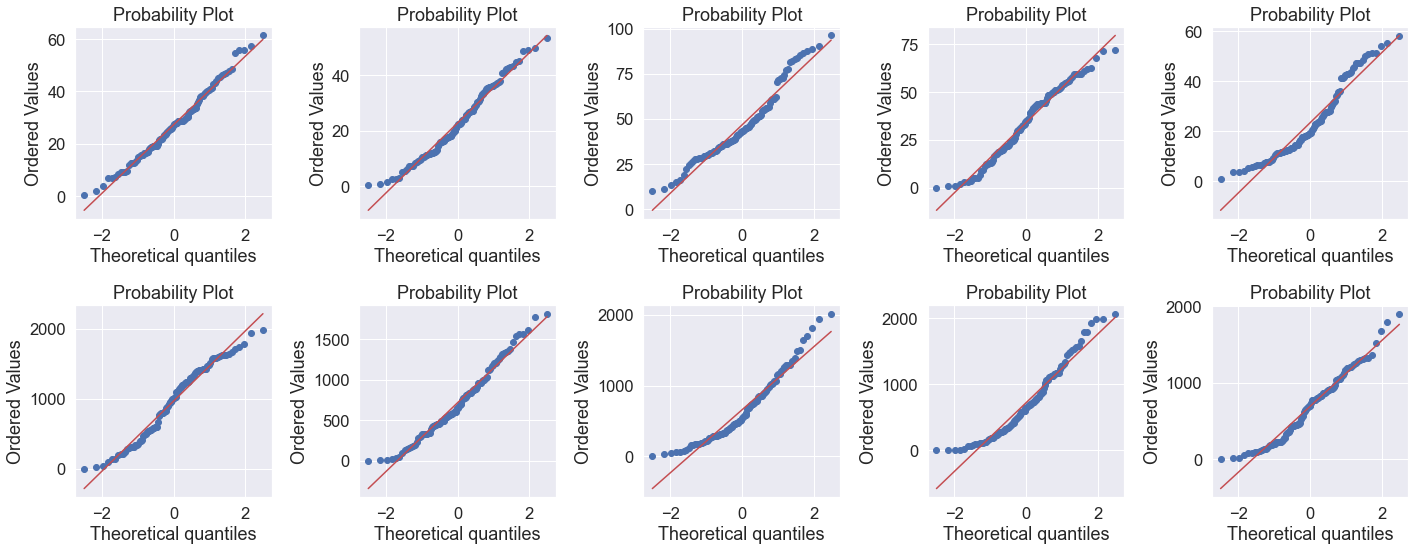

In [7]:
# test normality of mean and variance of ratings
print('mean: ' + str(emostats.test_normality(np.nanmean(mood_ratings_split[1:,:,:,0],axis=0))))
print('variance: ' + str(emostats.test_normality(np.nanvar(mood_ratings_split[1:,:,:,0],axis=0))))
fig,axs = plt.subplots(2,5,figsize=(20,8))
for j in range(5):
    scipy.stats.probplot(np.nanmean(mood_ratings_split[1:,j,:,0],axis=0), plot=axs[0,j])
    scipy.stats.probplot(np.nanvar(mood_ratings_split[1:,j,:,0],axis=0), plot=axs[1,j])
plt.tight_layout()

In [8]:
# table average ratings split in intervention group and before and after
condition_label = ['emotion regulation intervention', 'control intervention']
mood_ratings_split = np.empty((int(np.shape(mood_ratings)[0]/2), \
                               np.shape(mood_ratings)[1], np.shape(mood_ratings)[2], 2))
for i in range(2):
    print(condition_label[i] +' group:')
    mm = []
    T = np.shape(mood_ratings[:,:,0])[0]
    for t in range(2):
        mood_ratings_split[:,:,:,t] = mood_ratings[t*int(T/2):t*int(T/2) + int(T/2),:,:]
        mm.append(np.nanmean(mood_ratings_split[:,:,(df['randomized_condition']==i), t],axis=(0,2)))
        mm.append(np.nanmean(np.nanstd(mood_ratings_split[:,:,(df['randomized_condition']==i), t],axis=0),axis=1))
    display(pd.DataFrame(mm, columns=mood_categories, \
                             index=['mean before', 'std before', 'mean after', 'std after']).T.round(2))

emotion regulation intervention group:


,mean before,std before,mean after,std after
disgusted,27.07,31.47,29.21,30.15
amused,24.79,27.17,22.00,24.83
calm,46.83,24.47,46.50,21.47
anxious,33.55,26.20,36.14,24.20
sad,22.40,26.29,25.33,26.42


control intervention group:


,mean before,std before,mean after,std after
disgusted,26.63,27.85,15.90,18.64
amused,21.01,23.49,15.41,16.09
calm,47.23,23.89,57.95,15.77
anxious,33.81,22.92,20.61,15.10
sad,23.99,23.09,14.97,15.13


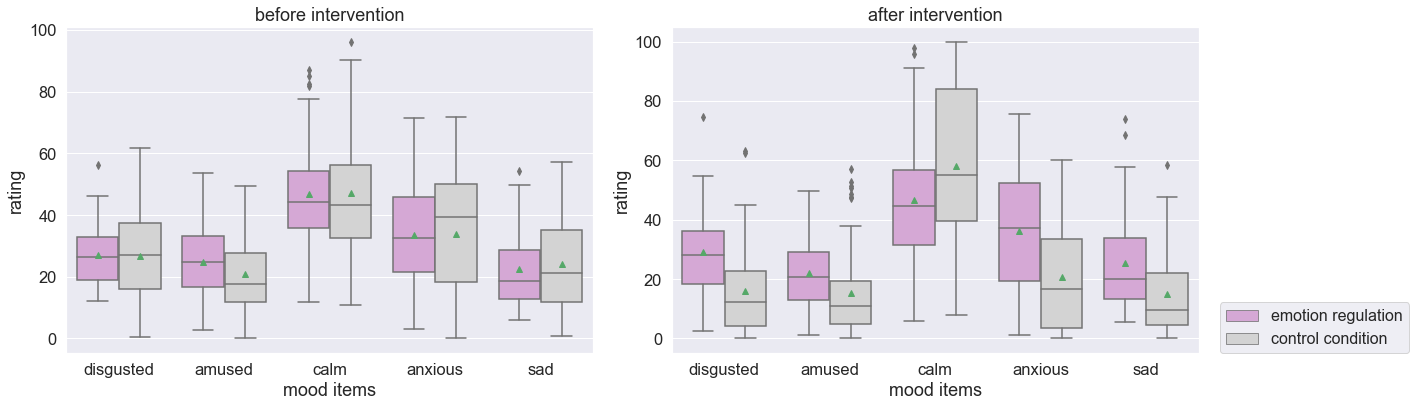

In [9]:
# plot showing mean before and after intervention split for condition
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
my_pal = {"left": "blue", "right": "red"}
time_label = ['before intervention', 'after intervention']
fig, axs = plt.subplots(1,2, figsize=[20,6])
for t in range(2):
    tmp = pd.DataFrame(np.nanmean(mood_ratings[t*int(T/2):t*int(T/2) + int(T/2),:,:],axis=0).T, \
                       columns=mood_categories)
    tmp['condition'] = df['randomized_condition']
    tmp = tmp.melt(id_vars=['condition'], value_vars=mood_categories, value_name='rating', var_name='category')
    b = sns.boxplot(data=tmp, x='category', y='rating', hue='condition', \
                    showmeans=True, ax = axs[t], palette={0: "plum", 1: "lightgrey"}) \
                    #meanprops={"markerfacecolor":"grey", "markeredgecolor":"grey"})
    b.set(title=time_label[t], ylabel='rating', xlabel='mood items')
    if t == 1: 
        b.legend(loc=(1.04, 0), fontsize=16)
        b.legend_.texts[0].set_text('emotion regulation')
        b.legend_.texts[1].set_text('control condition')
    else: 
            b.legend([],[], frameon=False)
fig.tight_layout()

,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,6.53,1.26,0.288,10.05,1.93,0.095
after intervention,24.48,4.71,< 0.001,36.53,7.03,< 0.001
change (after - before),52.66,10.14,< 0.001,19.90,3.83,0.003


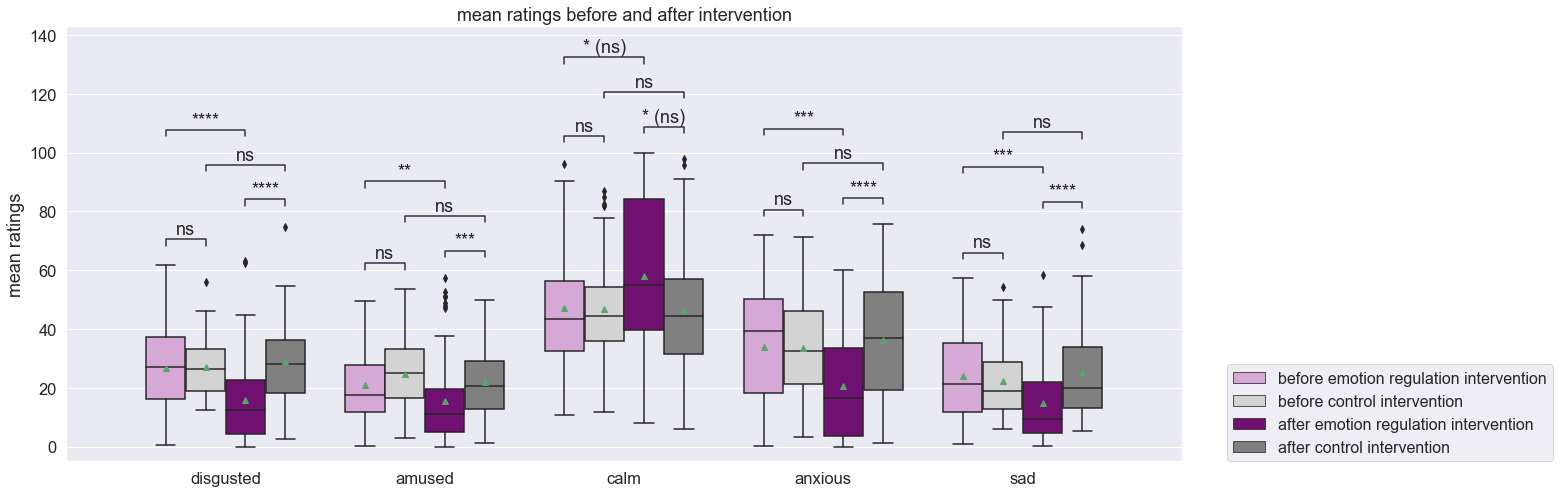

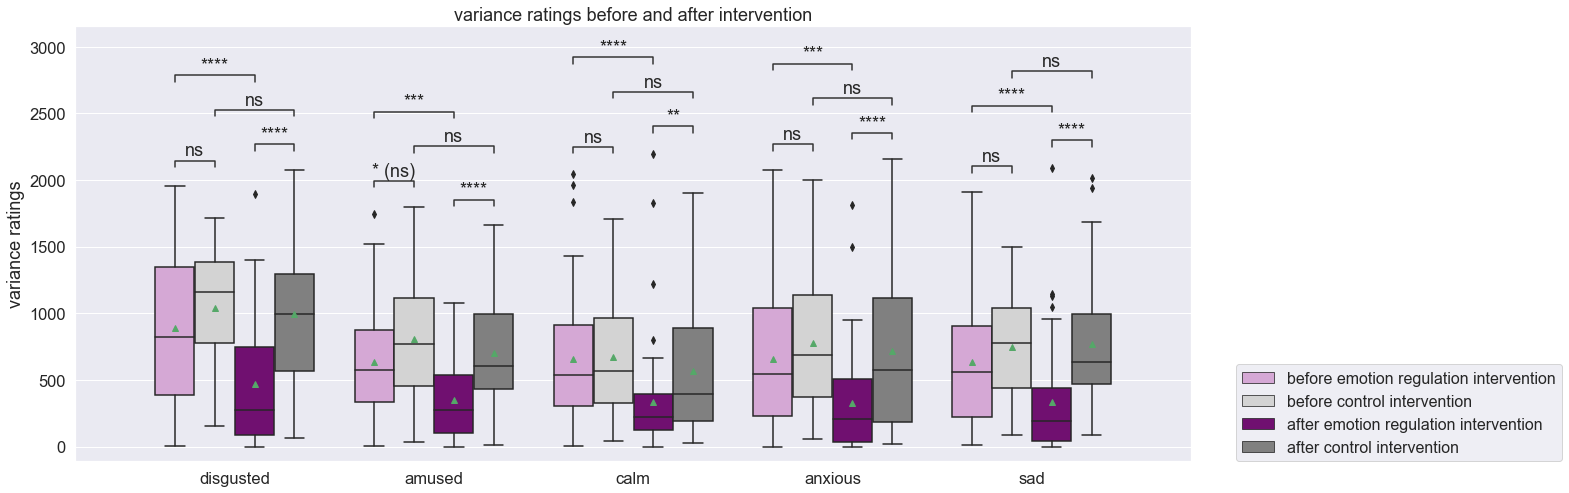

In [10]:
#  all in one plots showing ratings averaged over participants and HotellingTtest table
label= ['mean', 'variance']
pairs = []
for t in range(2):
    for i in mood_categories:
        pairs.append([(i, 0+t), (i, 2+t)])
        pairs.append([(i, t+(t*1)), (i, t+(t*1)+1)])
        
df_stats_both = pd.DataFrame()
for j, i in enumerate([np.nanmean(mood_ratings_split,axis=0), np.nanvar(mood_ratings_split,axis=0)]):
    df_stats, pvalues, tvalues = emostats.stats_group_difference(i, df)
    df_plot = emostats.make_df(i, df, mood_categories)
    fig, ax = plt.subplots(figsize=(20,8))
    fig, ax = emostats.plot_group_difference(df=df_plot, data_labels=mood_categories, \
                                             data_name=label[j] + ' ratings' , pairs=pairs, fig=fig, ax=ax)
    ax.set(ylabel=label[j] + ' ratings')
    df_stats_both = pd.concat((df_stats_both, df_stats), axis=1)

display(df_stats_both)
# print(df_stats_both.to_latex())

In [11]:
# statistics table including group comparisons and before and after comparisons 
print('multiple comparison: ' + str(0.05/15))
df_stats = pd.DataFrame()
for j in [np.nanmean(mood_ratings_split,axis=0), np.nanvar(mood_ratings_split,axis=0)]:
    pval, statistics = [np.empty((4,5)) for i in range(2)]
    mm1, mm2 = [np.empty((4,5), dtype=object) for i in range(2)]
    
    for t in range(2):
        for i in range(5):
            dd = j[i,:,t]
            statistics[t,i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],\
                                                       dd[df['randomized_condition']==1]).statistic
            pval[t,i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],\
                                                 dd[df['randomized_condition']==1]).pvalue
            mm1[t,i] = str(int(np.round(np.nanmean(dd[df['randomized_condition']==0])))) + '$\pm$' + \
                       str(int(np.round(np.nanstd(dd[df['randomized_condition']==0]))))
            mm2[t,i] = str(int(np.round(np.nanmean(dd[df['randomized_condition']==1])))) + '$\pm$' + \
                       str(int(np.round(np.nanstd(dd[df['randomized_condition']==1]))))
    for g in range(2):
        for i in range(5):
            dd = j[i,:,:]
            statistics[g+2,i] = scipy.stats.wilcoxon(dd[df['randomized_condition']==g,0],\
                                                   dd[df['randomized_condition']==g,1]).statistic
            pval[g+2,i] = scipy.stats.wilcoxon(dd[df['randomized_condition']==g,0],\
                                             dd[df['randomized_condition']==g,1]).pvalue
            mm1[g+2,i] = str(int(np.round(np.nanmean(dd[df['randomized_condition']==g,0])))) + '$\pm$' + \
                       str(int(np.round(np.nanstd(dd[df['randomized_condition']==g,0]))))
            mm2[g+2,i] = str(int(np.round(np.nanmean(dd[df['randomized_condition']==g,1])))) + '$\pm$' + \
                       str(int(np.round(np.nanstd(dd[df['randomized_condition']==g,1]))))
    statsarray = np.empty((4,20),dtype=object)
    for i in range(4):
        for j in range(5):
            statsarray[i,j*4] = mm1[i,j]
            statsarray[i,j*4+1] = mm2[i,j]
            statsarray[i,j*4+2] = np.round(statistics[i,j],2)
            if pval[i,j] < 0.001:statsarray[i,j*4+3] = '$<$0.001'
            else: statsarray[i,j*4+3] = np.round(pval[i,j],3)
    header = [np.repeat(mood_categories,4), len(mood_categories) * ['v1 (M$\pm$SD)', 'v2 (M$\pm$SD)', 'statistics', 'pvalue']]
    df_stats = pd.concat((df_stats, pd.DataFrame(statsarray, index=['group comparison at t=0', 'group comparison t=1', \
                            'before vs after g=0', 'before vs after g=1'], columns=header)))
df_stats.index =  [np.repeat(['mean', 'variance'], 4), df_stats.index]
df_stats.round(2)
# print(df_stats.round(2).to_latex(escape=False))

multiple comparison: 0.0033333333333333335


disgusted                           \
                                 v1 (M$\pm$SD) v2 (M$\pm$SD) statistics   
mean     group comparison at t=0     27$\pm$10     27$\pm$15     1514.5   
         group comparison t=1        29$\pm$14     16$\pm$15     2219.0   
         before vs after g=0         27$\pm$10     29$\pm$14      525.5   
         before vs after g=1         27$\pm$15     16$\pm$15      152.0   
variance group comparison at t=0  1041$\pm$409   888$\pm$549     1705.0   
         group comparison t=1      992$\pm$517   472$\pm$451     2255.0   
         before vs after g=0      1041$\pm$409   992$\pm$517      616.0   
         before vs after g=1       888$\pm$549   472$\pm$451      147.0   

                                                  amused                \
                                    pvalue v1 (M$\pm$SD) v2 (M$\pm$SD)   
mean     group comparison at t=0      0.71     25$\pm$11     21$\pm$13   
         group comparison t=1     $<$0.001     22$\pm$13     15$\pm$16   
         before vs after g=0         0.197     25$\pm$11     22$\pm$13   
         before vs after g=1      $<$0.001     21$\pm$13     15$\pm$16   
variance group comparison at t=0     0.122   804$\pm$422   633$\pm$399   
         group comparison t=1     $<$0.001   703$\pm$434   349$\pm$317   
         before vs after g=0          0.66   804$\pm$422   703$\pm$434   
         before vs after g=1      $<$0.001   633$\pm$399   349$\pm$317   

                                                               calm  \
                                 statistics    pvalue v1 (M$\pm$SD)   
mean     group comparison at t=0     1738.5      0.08     47$\pm$18   
         group comparison t=1        1997.0  $<$0.001     46$\pm$22   
         before vs after g=0          273.0  $<$0.001     47$\pm$18   
         before vs after g=1          308.0  $<$0.001     47$\pm$20   
variance group comparison at t=0     1787.0      0.04   673$\pm$435   
         group comparison t=1        2164.0  $<$0.001   564$\pm$478   
         before vs after g=0          345.0     0.003   673$\pm$435   
         before vs after g=1          246.0  $<$0.001   660$\pm$475   

                                                                     \
                                 v2 (M$\pm$SD) statistics    pvalue   
mean     group comparison at t=0     47$\pm$20     1497.0     0.791   
         group comparison t=1        58$\pm$26     1083.5     0.023   
         before vs after g=0         46$\pm$22      560.5     0.337   
         before vs after g=1         58$\pm$26      279.0  $<$0.001   
variance group comparison at t=0   660$\pm$475     1502.0     0.768   
         group comparison t=1      331$\pm$395     1924.0     0.004   
         before vs after g=0       564$\pm$478      323.0     0.001   
         before vs after g=1       331$\pm$395      133.0  $<$0.001   

                                       anxious                           \
                                 v1 (M$\pm$SD) v2 (M$\pm$SD) statistics   
mean     group comparison at t=0     34$\pm$16     34$\pm$20     1422.0   
         group comparison t=1        36$\pm$20     21$\pm$18     2091.0   
         before vs after g=0         34$\pm$16     36$\pm$20      471.0   
         before vs after g=1         34$\pm$20     21$\pm$18       68.0   
variance group comparison at t=0   778$\pm$511   654$\pm$529     1682.0   
         group comparison t=1      715$\pm$569   330$\pm$377     2098.0   
         before vs after g=0       778$\pm$511   715$\pm$569      566.0   
         before vs after g=1       654$\pm$529   330$\pm$377      187.0   

                                                     sad                \
                                    pvalue v1 (M$\pm$SD) v2 (M$\pm$SD)   
mean     group comparison at t=0     0.849     22$\pm$12     24$\pm$16   
         group comparison t=1     $<$0.001     25$\pm$16     15$\pm$14   
         before vs after g=0         0.072     22$\pm$12     25$\pm$16   
  

In [12]:
# MANOVA including group and before and after interaction
from statsmodels.multivariate.manova import MANOVA
for j, i in enumerate([np.nanmean(mood_ratings_split,axis=0), \
                       np.nanvar(mood_ratings_split,axis=0)]):
    print(['mean', 'variance'][j])
    df_manova = pd.DataFrame()
    for t in range(2):
        df_manova = pd.concat((df_manova, pd.DataFrame(i[:,:,t])),axis=1, \
                            ignore_index=True)
    df_manova = df_manova.T
    # df_test.columns = [i + str(t) for t in range(2) for i in mood_categories]
    df_manova.columns = mood_categories
    df_manova['time'] = np.concatenate((np.zeros([108,1]),np.ones([108,1])))
    df_manova['condition'] = np.concatenate((df['randomized_condition'].values,df['randomized_condition'].values))
    fit = MANOVA.from_formula('disgusted + amused + calm + anxious + sad ~ condition*time', data=df_manova)
    display(fit.mv_test().summary_frame)

mean


Value Num DF Den DF     F Value  \
Effect         Statistic                                                    
Intercept      Wilks' lambda           0.188486      5  208.0  179.105491   
               Pillai's trace          0.811514    5.0  208.0  179.105491   
               Hotelling-Lawley trace   4.30542      5  208.0  179.105491   
               Roy's greatest root      4.30542      5    208  179.105491   
condition      Wilks' lambda           0.975054      5  208.0    1.064301   
               Pillai's trace          0.024946    5.0  208.0    1.064301   
               Hotelling-Lawley trace  0.025584      5  208.0    1.064301   
               Roy's greatest root     0.025584      5    208    1.064301   
time           Wilks' lambda           0.977691      5  208.0    0.949219   
               Pillai's trace          0.022309    5.0  208.0    0.949219   
               Hotelling-Lawley trace  0.022818      5  208.0    0.949219   
               Roy's greatest root     0.022818      5    208    0.949219   
condition:time Wilks' lambda           0.941113      5  208.0    2.602998   
               Pillai's trace          0.058887    5.0  208.0    2.602998   
               Hotelling-Lawley trace  0.062572      5  208.0    2.602998   
               Roy's greatest root     0.062572      5    208    2.602998   

                                         Pr > F  
Effect         Statistic                         
Intercept      Wilks' lambda                0.0  
               Pillai's trace               0.0  
               Hotelling-Lawley trace       0.0  
               Roy's greatest root          0.0  
condition      Wilks' lambda           0.381261  
               Pillai's trace          0.381261  
               Hotelling-Lawley trace  0.381261  
               Roy's greatest root     0.381261  
time           Wilks' lambda           0.450169  
               Pillai's trace          0.450169  
               Hotelling-Lawley trace  0.450169  
               Roy's greatest root     0.450169  
condition:time Wilks' lambda           0.026208  
               Pillai's trace          0.026208  
               Hotelling-Lawley trace  0.026208  
               Roy's greatest root     0.026208

variance


Value Num DF Den DF    F Value  \
Effect         Statistic                                                   
Intercept      Wilks' lambda           0.415844      5  208.0  58.437553   
               Pillai's trace          0.584156    5.0  208.0  58.437553   
               Hotelling-Lawley trace  1.404749      5  208.0  58.437553   
               Roy's greatest root     1.404749      5    208  58.437553   
condition      Wilks' lambda           0.960274      5  208.0   1.720959   
               Pillai's trace          0.039726    5.0  208.0   1.720959   
               Hotelling-Lawley trace  0.041369      5  208.0   1.720959   
               Roy's greatest root     0.041369      5    208   1.720959   
time           Wilks' lambda           0.970623      5  208.0    1.25907   
               Pillai's trace          0.029377    5.0  208.0    1.25907   
               Hotelling-Lawley trace  0.030266      5  208.0    1.25907   
               Roy's greatest root     0.030266      5    208    1.25907   
condition:time Wilks' lambda           0.960255      5  208.0   1.721829   
               Pillai's trace          0.039745    5.0  208.0   1.721829   
               Hotelling-Lawley trace   0.04139      5  208.0   1.721829   
               Roy's greatest root      0.04139      5    208   1.721829   

                                         Pr > F  
Effect         Statistic                         
Intercept      Wilks' lambda                0.0  
               Pillai's trace               0.0  
               Hotelling-Lawley trace       0.0  
               Roy's greatest root          0.0  
condition      Wilks' lambda           0.131124  
               Pillai's trace          0.131124  
               Hotelling-Lawley trace  0.131124  
               Roy's greatest root     0.131124  
time           Wilks' lambda           0.282971  
               Pillai's trace          0.282971  
               Hotelling-Lawley trace  0.282971  
               Roy's greatest root     0.282971  
condition:time Wilks' lambda           0.130926  
               Pillai's trace          0.130926  
               Hotelling-Lawley trace  0.130926  
               Roy's greatest root     0.130926

Difference in slider time explaining the mean rating difference?
--

In [17]:
T = 110
rt = np.empty((len(data),2))
rand = np.empty((len(data)))
for i in range(len(data)):
    for t in range(2):
        rt[i,t] = np.nanmean(data[i]['slider_rt'][t*int(T/2):int(T/2)+t*int(T/2)])
diff_rt = rt[:,1] - rt[:,0]

,sum_sq,df,F,PR(>F)
C(time),2.584283e+07,1.0,3.278267,0.071619
C(randomized_condition),2.175115e+06,1.0,0.275922,0.599935
C(time):C(randomized_condition),6.723063e+06,1.0,0.852848,0.356798
Residual,1.671212e+09,212.0,NaN,NaN


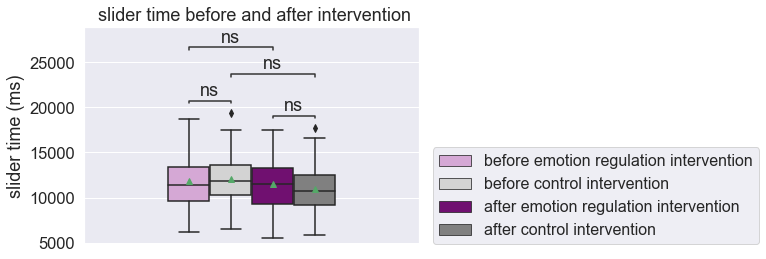

In [18]:
fig, ax = plt.subplots(figsize=(6,4))
df_plot = emostats.make_df(rt, df, ['rt'])
pairs = []
for t in range(2):
    i = 'rt'
    pairs.append([(i, 0+t), (i, 2+t)])
    pairs.append([(i, t+(t*1)), (i, t+(t*1)+1)])
emostats.plot_group_difference(df=df_plot, data_labels=['rt'], data_name=' slider time',pairs=pairs, test = 't-test_ind', \
                              ax = ax, fig=fig);
ax.set(ylabel='slider time (ms)', xticks=[])

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
df_melt = pd.melt(pd.concat((df['randomized_condition'], pd.DataFrame(rt)),axis=1).reset_index(), \
        id_vars=['randomized_condition', 'index'], value_name='rt', var_name='time')
model = ols('rt ~ C(time) + C(randomized_condition) + C(time):C(randomized_condition)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

----
Symptoms
--

In [19]:
# data of 3 psychological questionnaires were collected
questionnaires = {'phq': range(0,10), 'gad': range(10,10+7), 'ders': range(17,17+18)}
for i in questionnaires.items():
    df[i[0]] = np.sum(symptoms[:,i[1]],axis=1)
    df[i[0] + '_zscore'] = prep.zscore(df[i[0]])
symptoms_normalized = prep.zscore(symptoms)
df.to_csv('../results/questionnaire_data.csv')

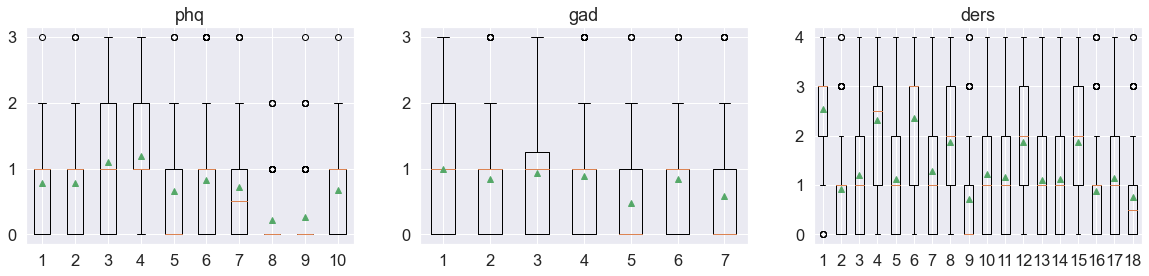

In [20]:
fi,ax = plt.subplots(1,3,figsize=(20,4))
for j,i in enumerate(questionnaires.items()):
    ax[j].boxplot(symptoms[:,i[1]], showmeans=True);
    ax[j].set_title(i[0])

In [21]:
# correlation between questionnaires
display(df[questionnaires.keys()].corr())

,phq,gad,ders
phq,1.000000,0.753185,0.690018
gad,0.753185,1.000000,0.732192
ders,0.690018,0.732192,1.000000


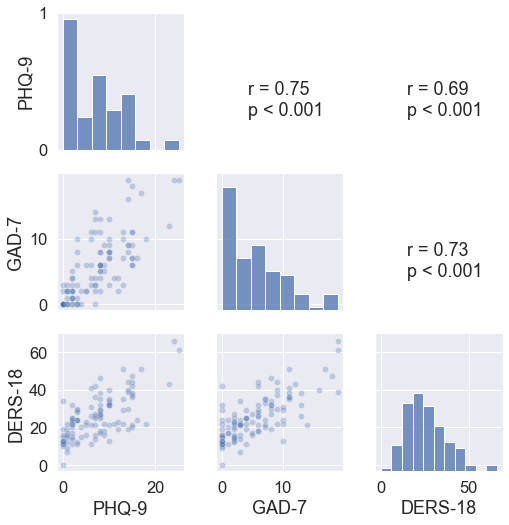

In [22]:
questionnaire_label = ['PHQ-9', 'GAD-7', 'DERS-18']
def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = scipy.stats.pearsonr(x,y)
    if p < 0.001: p = '< 0.001'
    else: p = '= ' + str(np.round(p,2))
    ax.annotate('r = ' + str(np.round(r,2)) + '\np ' + p, xy=(0.25,0.25), xycoords='axes fraction', ha='left')
    ax.set_axis_off()

g = sns.PairGrid(df[questionnaires.keys()], hue=None)
g.map_upper(reg_coef, hue=None)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot, alpha=0.3)
k,j = 0,0
for i, ax in enumerate(g.axes.flat):
    if i == 0: 
        ax.set_yticks([0,1])
        ax.set_yticklabels([0,1])
    if i in [0,3,6]: 
        ax.set_ylabel(questionnaire_label[k])
        k += 1
    if i > 5: 
        ax.set_xlabel(questionnaire_label[j])
        j += 1
if savefig:
    plt.savefig(filepath + 'results/figures/questionnaires.svg')

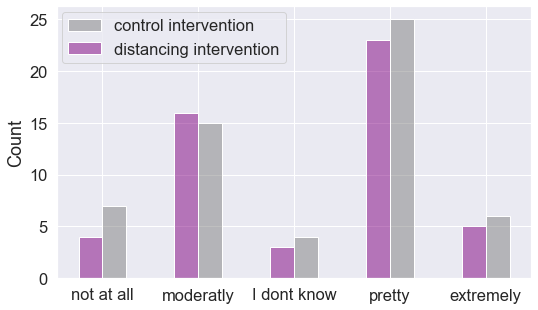

In [23]:
# histogram showing how successfull they thought they were using the intervention
fig,axs = plt.subplots(figsize=(8.5,5))
b = sns.histplot(data=df, x='intervention_success', hue='randomized_condition', multiple="dodge", \
                 shrink=0.5, ax=axs ,discrete=True, palette={0: "purple", 1: "grey"}, legend=False, alpha=0.5)
b.set_xlabel('');
b.set_xticks(range(5));
b.set_xticklabels(['not at all', 'moderatly', 'I dont know', 'pretty', 'extremely']);
b.legend(['control intervention','distancing intervention'],loc=(0.01, 0.79))
if savefig:
    plt.savefig(filepath + 'results/figures/intervention_success.svg')

In [24]:
# relation between DERS and intervention success
print(scipy.stats.spearmanr(df['ders'], df['intervention_success']))
display(smf.glm('intervention_success ~ ders', df, missing='drop').fit().summary().tables[1])
model = smf.glm('intervention_success ~ ders * randomized_condition', df, missing='drop').fit()
df_new = pd.DataFrame(model.summary().tables[1][1:], columns=model.summary().tables[1][0])
df_new = df_new.iloc[: , 1:]
df_new.index = ['Intercept', 'DERS-18', 'intervention', 'intervention * DERS-18']
display(df_new)
# dfi.export(df_new, filepath + 'results/figures/interventionsuccessVSDERS.png')

SpearmanrResult(correlation=-0.2318134156516171, pvalue=0.015777453888499843)


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.8253,0.279,10.120,0.000,2.278,3.372
ders,-0.0262,0.010,-2.630,0.009,-0.046,-0.007


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.7566,0.398,6.924,0.000,1.976,3.537
DERS-18,-0.0225,0.014,-1.612,0.107,-0.050,0.005
intervention,0.1483,0.564,0.263,0.793,-0.957,1.254
intervention * DERS-18,-0.0078,0.020,-0.389,0.697,-0.047,0.032


the higher they score in DERS the lower they judged their intervention success,
however does not seem specific to emotion regulation intervention

----
Relation with symptoms
--

In [25]:
# relation betweeen mean and variance of emotion ratings (baseline, before and after intervention) 
# and the three questionnaires
df_mood = df.copy()
timing = {'baseline': mood_ratings[0,:,:].T, \
          'mean_t1': np.nanmean(mood_ratings[1:int(np.shape(mood_ratings)[0]/2),:,:],axis=0).T, \
          'mean_t2': np.nanmean(mood_ratings[int(np.shape(mood_ratings)[0]/2)+1:,:,:],axis=0).T, \
          'mean_change': np.nanmean(mood_ratings[int(np.shape(mood_ratings)[0]/2)+1:,:,:],axis=0).T - \
          np.nanmean(mood_ratings[1:int(np.shape(mood_ratings)[0]/2),:,:],axis=0).T, \
          'var_t1': np.nanvar(mood_ratings[1:int(np.shape(mood_ratings)[0]/2),:,:],axis=0).T, \
          'var_t2': np.nanvar(mood_ratings[int(np.shape(mood_ratings)[0]/2)+1:,:,:],axis=0).T,
         }
for j in timing.items():
    mood_columns = [i + '_' + j[0] for i in mood_categories]
    tmp = pd.DataFrame(j[1],columns=mood_columns)
    df_mood = pd.concat((df_mood,tmp), axis=1)
    for i in mood_columns: df_mood[i] = prep.zscore(df_mood[i])

In [26]:
formula = [[' ~ ', [1]], \
           [' ~ randomized_condition * ', [1,2,3]]]
stats_items = [0, 3, 4, 5]
df_stats_all = []
for q in [i + '_zscore' for i in questionnaires.keys()]:
    df_stats = pd.DataFrame()
    for m in mood_categories:
        glmstats, idx = [], []
        mood_columns = [i for i in df_mood.columns if m in i]
        for d, k in enumerate(mood_columns):
            if '1' in k: glm_formula = formula[0]
            elif '2' in k or 'change' in k: glm_formula = formula[1]
            else: glm_formula = [' ~ ', [1]]
            model = smf.glm(k + glm_formula[0] + q, df_mood, missing='drop').fit()
            for g in glm_formula[1]:
                tmp = prep.convert_stats_table(model,g)
                glmstats.append([tmp.values[i] for i in stats_items])
                idx.append(tmp.name + ' -> ' + list(timing.keys())[d]) 
        statscolumns = [tmp.index[i] for i in stats_items] 
        header = [np.repeat(np.array(m),4), 
                    np.array(statscolumns)] 
        df_stats = pd.concat((df_stats, \
                              pd.DataFrame(glmstats, \
                                           columns=header, index=idx)),axis=1)
    idx = []
    for m in mood_categories:
        idx.append(df_stats[(m, 'P>|z|')] < 0.001)
    df_stats = df_stats.round(3)
    for i,m in enumerate(mood_categories): df_stats[(m, 'P>|z|')][idx[i]] = '$<0.001$'
    display(df_stats)
    df_stats_all.append(df_stats)
#     print(df_stats.to_latex(escape=False))

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_67361/2463345350.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i,m in enumerate(mood_categories): df_stats[(m, 'P>|z|')][idx[i]] = '$<0.001$'


disgusted                   \
                                                    coef     P>|z| [0.025   
phq_zscore -> baseline                             0.312     0.001  0.131   
phq_zscore -> mean_t1                              0.311     0.001  0.130   
randomized_condition -> mean_t2                   -0.866  $<0.001$ -1.208   
phq_zscore -> mean_t2                              0.117     0.381 -0.145   
randomized_condition:phq_zscore -> mean_t2         0.117     0.508 -0.229   
randomized_condition -> mean_change               -0.947  $<0.001$ -1.285   
phq_zscore -> mean_change                         -0.048     0.715 -0.306   
randomized_condition:phq_zscore -> mean_change    -0.059     0.733 -0.400   
phq_zscore -> var_t1                              -0.090     0.354 -0.279   
randomized_condition -> var_t2                    -0.947  $<0.001$ -1.287   
phq_zscore -> var_t2                               0.003      0.98 -0.256   
randomized_condition:phq_zscore -> var_t2          0.054     0.758 -0.289   

                                                      amused                   \
                                               0.975]   coef     P>|z| [0.025   
phq_zscore -> baseline                          0.493  0.056     0.566 -0.134   
phq_zscore -> mean_t1                           0.492  0.106     0.272 -0.083   
randomized_condition -> mean_t2                -0.524 -0.462     0.015 -0.836   
phq_zscore -> mean_t2                           0.378 -0.012     0.936 -0.297   
randomized_condition:phq_zscore -> mean_t2      0.462  0.150     0.435 -0.227   
randomized_condition -> mean_change            -0.610 -0.341     0.078 -0.720   
phq_zscore -> mean_change                       0.210  0.028     0.849 -0.261   
randomized_condition:phq_zscore -> mean_change  0.281 -0.126     0.518 -0.509   
phq_zscore -> var_t1                            0.100 -0.146     0.127 -0.335   
randomized_condition -> var_t2                 -0.607 -0.856  $<0.001$ -1.201   
phq_zscore -> var_t2                            0.263 -0.086     0.523 -0.349   
randomized_condition:phq_zscore -> var_t2       0.397  0.266     0.134 -0.082   

                                                        calm                   \
                                               0.975]   coef     P>|z| [0.025   
phq_zscore -> baseline                          0.246 -0.467  $<0.001$ -0.635   
phq_zscore -> mean_t1                           0.295 -0.184     0.054 -0.371   
randomized_condition -> mean_t2                -0.088  0.497     0.007  0.139   
phq_zscore -> mean_t2                           0.274 -0.173     0.215 -0.447   
randomized_condition:phq_zscore -> mean_t2      0.527 -0.180     0.328 -0.542   
randomized_condition -> mean_change             0.038  0.728  $<0.001$  0.379   
phq_zscore -> mean_change                       0.318 -0.098     0.472 -0.365   
randomized_condition:phq_zscore -> mean_change  0.256 -0.208     0.248 -0.561   
phq_zscore -> var_t1                            0.042 -0.256     0.006 -0.440   
randomized_condition -> var_t2                 -0.511 -0.494     0.009 -0.867   
phq_zscore -> var_t2                            0.177 -0.037     0.801 -0.321   
randomized_condition:phq_zscore -> var_t2       0.614 -0.052     0.785 -0.428   

                                                      anxious            \
                                               0.975]    coef     P>|z|   
phq_zscore -> baseline                         -0.298   0.521  $<0.001$   
phq_zscore -> mean_t1                           0.003   0.336  $<0.001$   
randomized_condition -> mean_t2                 0.856  -0.796  $<0.001$   
phq_zscore -> mean_t2                           0.101   0.140     0.292   
randomized_condition:phq_zscore -> mean_t2      0.181   0.198      0.26   
randomized_condition -> mean_change             1.078  -1.082  $<0.001$   
phq_zscore -> mean_change                       0.169  -0.156     0.213   
randomized_condition:ph

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_67361/2463345350.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i,m in enumerate(mood_categories): df_stats[(m, 'P>|z|')][idx[i]] = '$<0.001$'


disgusted                   \
                                                    coef     P>|z| [0.025   
gad_zscore -> baseline                             0.117     0.224 -0.072   
gad_zscore -> mean_t1                              0.288     0.002  0.105   
randomized_condition -> mean_t2                   -0.832  $<0.001$ -1.174   
gad_zscore -> mean_t2                             -0.040     0.738 -0.278   
randomized_condition:gad_zscore -> mean_t2         0.315      0.07 -0.026   
randomized_condition -> mean_change               -0.970  $<0.001$ -1.304   
gad_zscore -> mean_change                         -0.122     0.301 -0.355   
randomized_condition:gad_zscore -> mean_change    -0.038     0.824 -0.372   
gad_zscore -> var_t1                               0.101     0.295 -0.088   
randomized_condition -> var_t2                    -0.936  $<0.001$ -1.273   
gad_zscore -> var_t2                               0.016     0.894 -0.219   
randomized_condition:gad_zscore -> var_t2          0.140     0.416 -0.197   

                                                      amused                   \
                                               0.975]   coef     P>|z| [0.025   
gad_zscore -> baseline                          0.306 -0.006     0.951 -0.196   
gad_zscore -> mean_t1                           0.470  0.048     0.623 -0.142   
randomized_condition -> mean_t2                -0.491 -0.455     0.017 -0.829   
gad_zscore -> mean_t2                           0.197 -0.067     0.616 -0.327   
randomized_condition:gad_zscore -> mean_t2      0.657  0.123     0.519 -0.251   
randomized_condition -> mean_change            -0.636 -0.351     0.067 -0.727   
gad_zscore -> mean_change                       0.110  0.033     0.803 -0.228   
randomized_condition:gad_zscore -> mean_change  0.296 -0.220      0.25 -0.596   
gad_zscore -> var_t1                            0.291 -0.036     0.707 -0.227   
randomized_condition -> var_t2                 -0.599 -0.846  $<0.001$ -1.190   
gad_zscore -> var_t2                            0.251 -0.059     0.632 -0.299   
randomized_condition:gad_zscore -> var_t2       0.477  0.247      0.16 -0.097   

                                                        calm                   \
                                               0.975]   coef     P>|z| [0.025   
gad_zscore -> baseline                          0.184 -0.405  $<0.001$ -0.579   
gad_zscore -> mean_t1                           0.238 -0.301     0.001 -0.483   
randomized_condition -> mean_t2                -0.080  0.443     0.018  0.077   
gad_zscore -> mean_t2                           0.194 -0.175     0.178 -0.429   
randomized_condition:gad_zscore -> mean_t2      0.497 -0.082     0.661 -0.447   
randomized_condition -> mean_change             0.025  0.703  $<0.001$  0.342   
gad_zscore -> mean_change                       0.295  0.001     0.994 -0.250   
randomized_condition:gad_zscore -> mean_change  0.155  0.036     0.846 -0.325   
gad_zscore -> var_t1                            0.154 -0.117     0.225 -0.306   
randomized_condition -> var_t2                 -0.501 -0.505     0.008 -0.877   
gad_zscore -> var_t2                            0.181  0.026     0.842 -0.233   
randomized_condition:gad_zscore -> var_t2       0.592 -0.108      0.57 -0.480   

                                                      anxious            \
                                               0.975]    coef     P>|z|   
gad_zscore -> baseline                         -0.231   0.561  $<0.001$   
gad_zscore -> mean_t1                          -0.120   0.447  $<0.001$   
randomized_condition -> mean_t2                 0.808  -0.738  $<0.001$   
gad_zscore -> mean_t2                           0.080   0.180      0.13   
randomized_condition:gad_zscore -> mean_t2      0.283   0.230     0.178   
randomized_condition -> mean_change             1.064  -1.106  $<0.001$   
gad_zscore -> mean_change                       0.252  -0.131     0.245   
randomized_condition:ga

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_67361/2463345350.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i,m in enumerate(mood_categories): df_stats[(m, 'P>|z|')][idx[i]] = '$<0.001$'


disgusted                   \
                                                     coef     P>|z| [0.025   
ders_zscore -> baseline                             0.203     0.033  0.016   
ders_zscore -> mean_t1                              0.379  $<0.001$  0.203   
randomized_condition -> mean_t2                    -0.831  $<0.001$ -1.164   
ders_zscore -> mean_t2                              0.094     0.426 -0.137   
randomized_condition:ders_zscore -> mean_t2         0.288     0.089 -0.044   
randomized_condition -> mean_change                -0.962  $<0.001$ -1.299   
ders_zscore -> mean_change                         -0.074     0.533 -0.308   
randomized_condition:ders_zscore -> mean_change    -0.024     0.887 -0.361   
ders_zscore -> var_t1                               0.126     0.193 -0.063   
randomized_condition -> var_t2                     -0.938  $<0.001$ -1.272   
ders_zscore -> var_t2                               0.035     0.766 -0.197   
randomized_condition:ders_zscore -> var_t2          0.177       0.3 -0.158   

                                                       amused            \
                                                0.975]   coef     P>|z|   
ders_zscore -> baseline                          0.389 -0.015     0.877   
ders_zscore -> mean_t1                           0.555  0.060     0.535   
randomized_condition -> mean_t2                 -0.498 -0.452     0.017   
ders_zscore -> mean_t2                           0.325 -0.063      0.63   
randomized_condition:ders_zscore -> mean_t2      0.621  0.236     0.214   
randomized_condition -> mean_change             -0.625 -0.345     0.075   
ders_zscore -> mean_change                       0.159  0.007     0.956   
randomized_condition:ders_zscore -> mean_change  0.312 -0.008     0.968   
ders_zscore -> var_t1                            0.314  0.016     0.869   
randomized_condition -> var_t2                  -0.603 -0.845  $<0.001$   
ders_zscore -> var_t2                            0.267 -0.030     0.805   
randomized_condition:ders_zscore -> var_t2       0.512  0.300     0.084   

                                                                calm  \
                                                [0.025 0.975]   coef   
ders_zscore -> baseline                         -0.205  0.175 -0.387   
ders_zscore -> mean_t1                          -0.130  0.250 -0.396   
randomized_condition -> mean_t2                 -0.823 -0.080  0.446   
ders_zscore -> mean_t2                          -0.321  0.194 -0.211   
randomized_condition:ders_zscore -> mean_t2     -0.136  0.607 -0.215   
randomized_condition -> mean_change             -0.724  0.035  0.700   
ders_zscore -> mean_change                      -0.255  0.270 -0.032   
randomized_condition:ders_zscore -> mean_change -0.387  0.371  0.004   
ders_zscore -> var_t1                           -0.174  0.206 -0.076   
randomized_condition -> var_t2                  -1.186 -0.504 -0.506   
ders_zscore -> var_t2                           -0.266  0.207 -0.082   
randomized_condition:ders_zscore -> var_t2      -0.040  0.641  0.030   

                                                                         \
                                                    P>|z| [0.025 0.975]   
ders_zscore -> baseline                          $<0.001$ -0.563 -0.212   
ders_zscore -> mean_t1                           $<0.001$ -0.570 -0.221   
randomized_condition -> mean_t2                     0.013  0.094  0.798   
ders_zscore -> mean_t2                               0.09 -0.455  0.033   
randomized_condition:ders_zscore -> mean_t2          0.23 -0.567  0.136   
randomized_condition -> mean_change              $<0.001$  0.339  1.060   
ders_zscore -> mean_change                          0.804 -0.282  0.218   
randomized_condition:ders_zscore -> mean_change     0.981 -0.356  0.365   
ders_zscore -> var_t1                               0.431 -0.266  0.114   
randomized_condition -> var_t2                      0.008 -0.878 -0.13

In [481]:
from matplotlib.gridspec import SubplotSpec
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

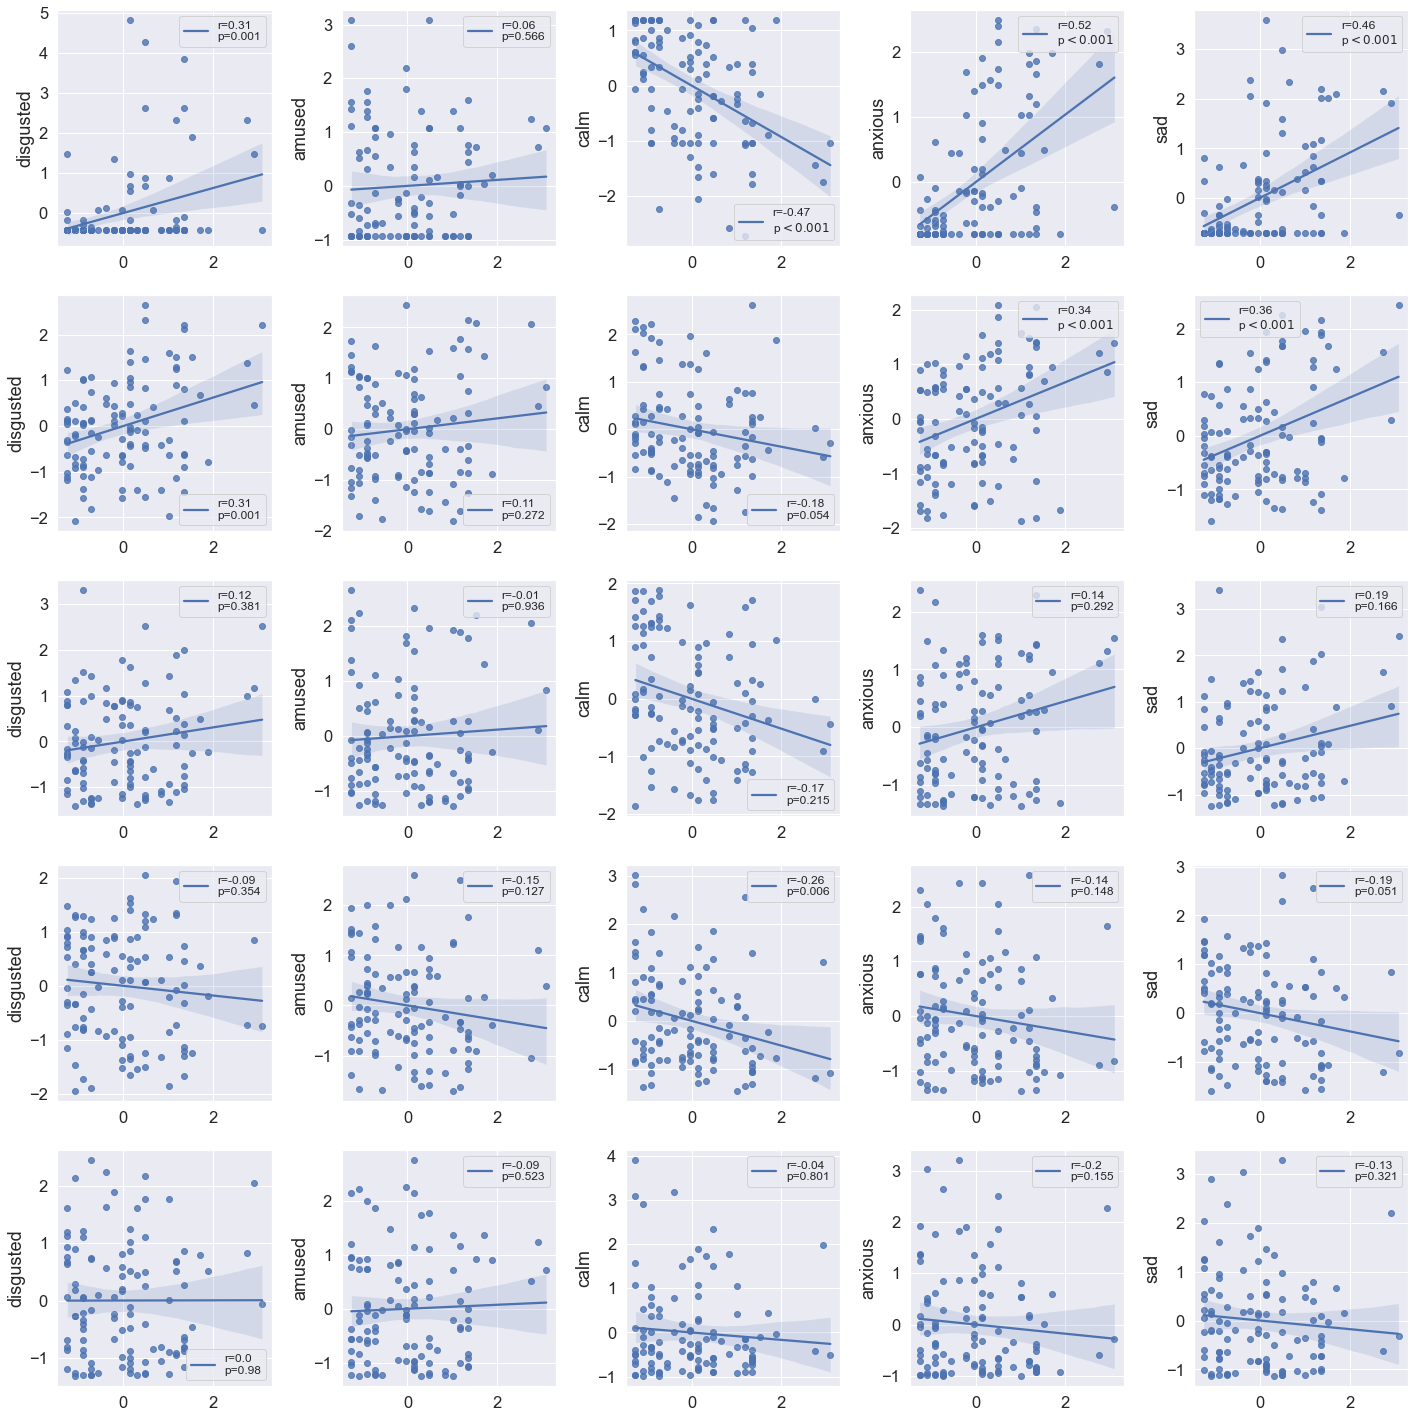

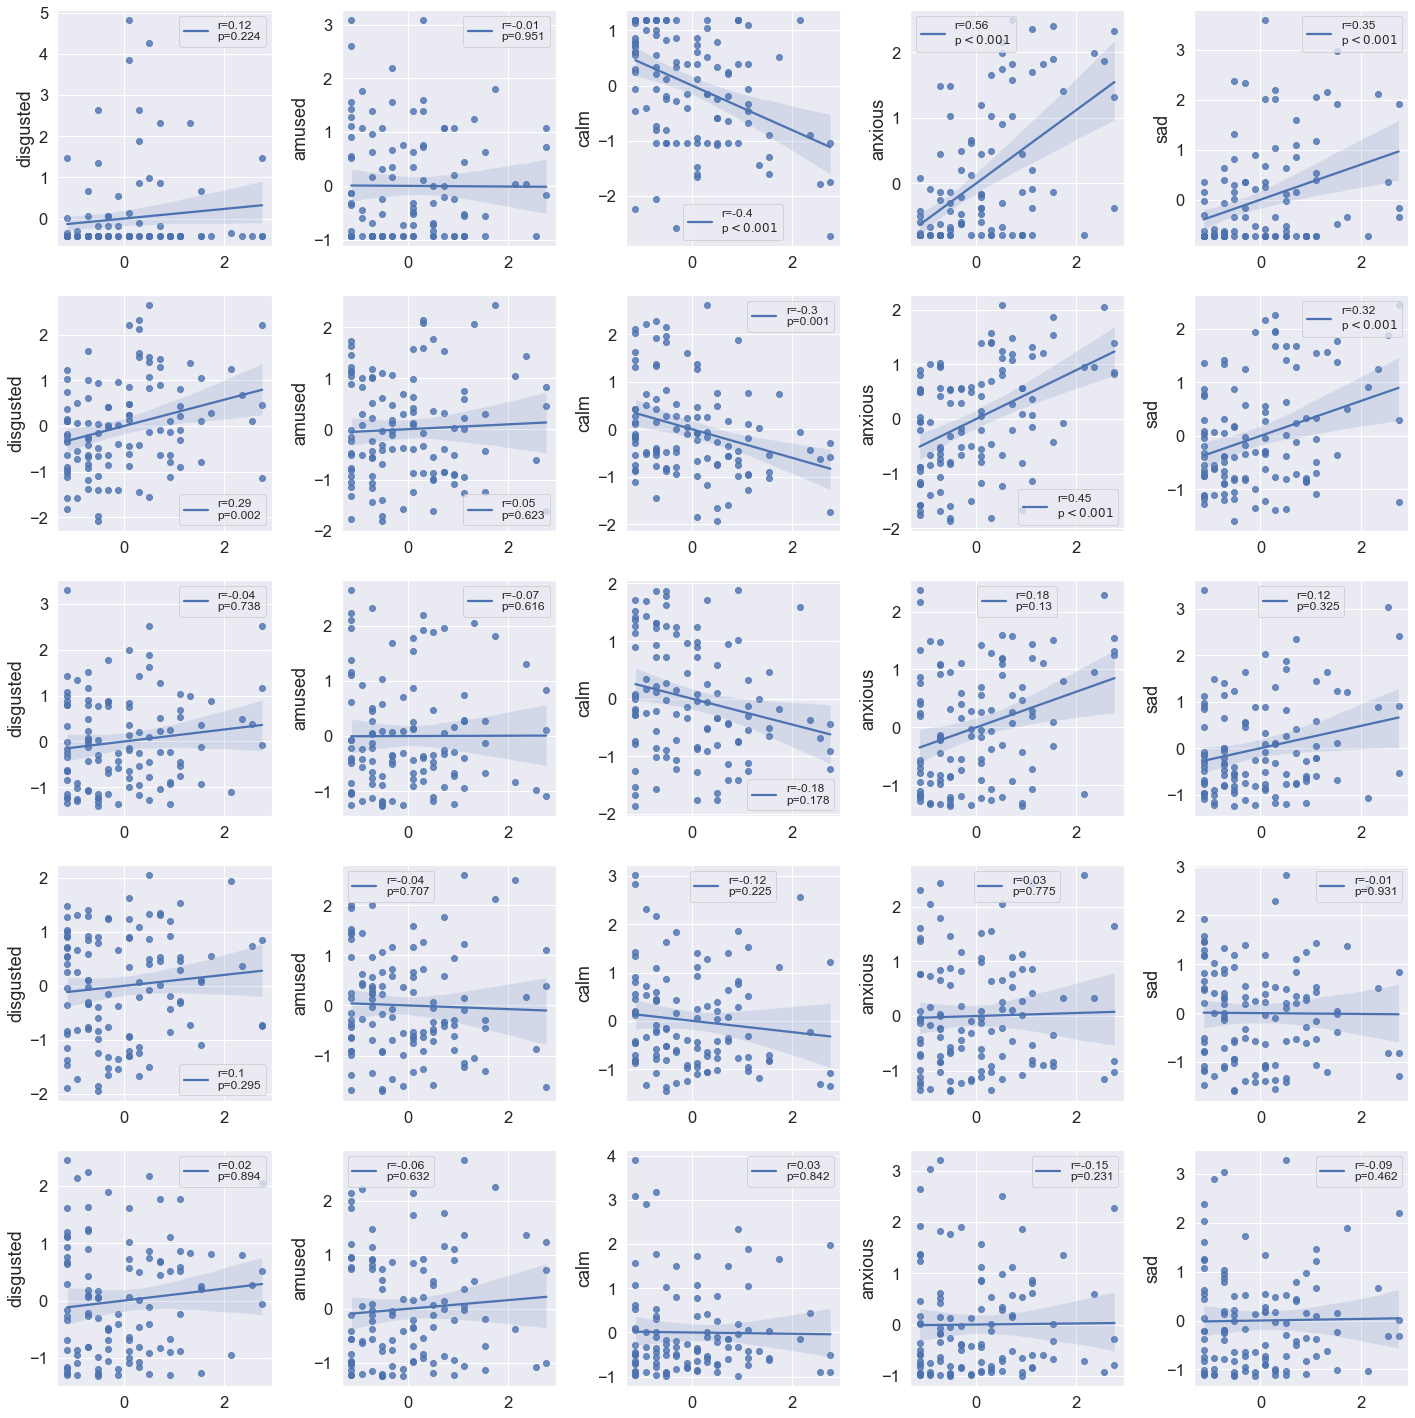

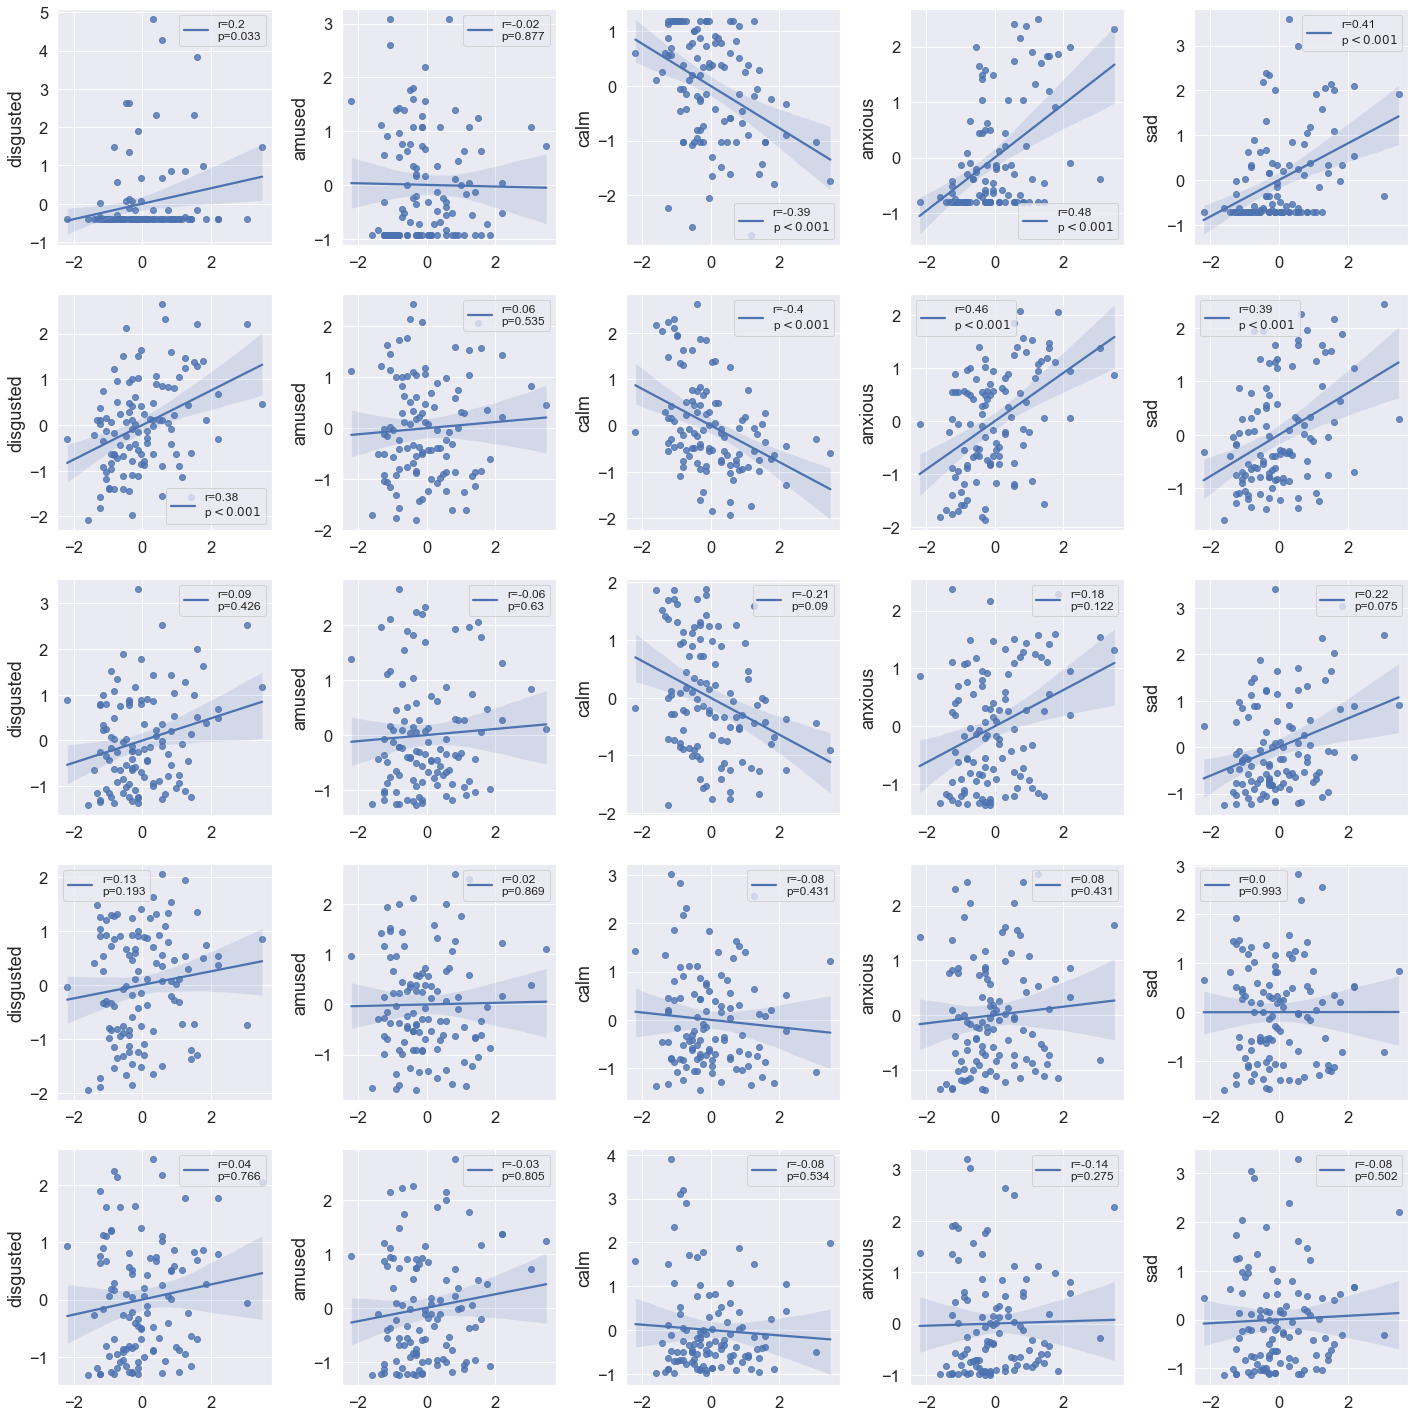

In [482]:
questionnaire_label = ['PHQ-9', 'GAD-7', 'DERS-18']
for r, q in enumerate([i + '_zscore' for i in questionnaires]):
    fig,axs= plt.subplots(len(timing), len(mood_categories), figsize=(20,20))
    grid = plt.GridSpec(len(timing), len(mood_categories))
    for m,t in enumerate(timing.keys()):
        c = [i for i in df_mood.columns if t in i]
        for n,cc in enumerate(c):
            slope = df_stats_all[r][(mood_categories[n],'coef')].loc[q + ' -> ' + t]
            p_value = df_stats_all[r][(mood_categories[n],'P>|z|')].loc[q + ' -> ' + t]
            if not (type(p_value) == str): p_value = '=' + str(np.round(p_value,3))
            b = sns.regplot(data = df_mood, x=q, y=cc, ax=axs[m,n], \
                            line_kws={'label': 'r=' + str(np.round(slope,2)) + '\np' + p_value})
            b.legend(prop={'size': 12})
            if m == len(timing): b.set(xlabel=questionnaire_label[r])
            else: b.set(xlabel='')
            b.set(ylabel=mood_categories[n])
#         create_subtitle(fig, grid[m, ::], list(timing.keys())[m])
    fig.tight_layout()
if savefig:
    plt.savefig(filepath + '/results/figures/' + q + '_basics.png')

In [24]:
# multiple comparison
0.05/15

0.0033333333333333335

In [43]:
print(np.corrcoef(df['intervention_success'][df['randomized_condition']==1], \
                  np.nanmean(np.abs(timing['mean_change'][df['randomized_condition']==1,:]),1))[0,1])

0.2749100075545486


In [42]:
for i in range(5):
    print(np.corrcoef(df['intervention_success'][df['randomized_condition']==1], \
                      timing['mean_change'][df['randomized_condition']==1,i])[0,1])

-0.2515006758053855
-0.05478427180447015
0.28964368064491985
-0.23028613531560263
-0.2735487296175299


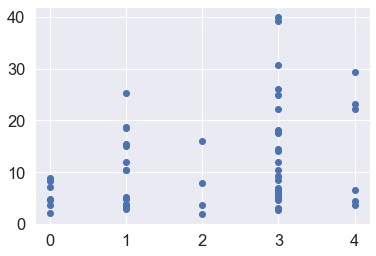

In [40]:
plt.scatter(df['intervention_success'][df['randomized_condition']==1], \
            np.nanmean(np.abs(timing['mean_change'][df['randomized_condition']==1,:]),1))

Test Re-Test
--

In [25]:
# find duplicated videos to see if the ratings are stable
df_finalVideoList = pd.read_csv('../experiment/public/prep/videosForExperiment.csv')

videopath = data[0]['datadoc']['video_path'].split(',')
videoclips =[]
for i, j in enumerate(videopath):
    if i == len(videopath)-1: videoclips.append(j[-11:-7])
    else: videoclips.append(j[-10:-6])
df_videoclips = pd.DataFrame(videoclips)
dublicates = df_videoclips[df_videoclips.duplicated()]

df_videoclips = pd.DataFrame(videoclips, columns=['videoclips'])
df_videoclips.loc[-1] = np.nan
df_videoclips.loc[53.5] = np.nan
df_videoclips = df_videoclips
duplicates = pd.unique(df_videoclips['videoclips'][df_videoclips.duplicated()].dropna())
for i in duplicates:
    df_videoclips == i


In [26]:
# calculate variance in ratings for same video
random_var=[]
for i in range(10000):
    random_var.append(np.var(np.round(np.random.uniform(0, 100, [3,5])),axis=0))
print('var in randomly generated ratings: ' + str(np.mean(random_var)))

nonrandom_var=[]
for i in range(10000):
    x = np.round(np.random.uniform(0, 100, [5,1]))
    x = np.repeat(x, 3, axis=1)
    x[:,1:] = np.round(x[:,1:] + np.random.normal(0, 10, [5,2]))
    nonrandom_var.append(np.var(x,axis=1))
print('var in closely (± N(0,10)) generated ratings: ' + str(np.mean(nonrandom_var)))

ratematching_duplicates = np.full([3,5,4,Nsj], np.nan)
video_cat = []
for sj in range(Nsj):
    for v in range(2):
        duplicates = np.unique(df_finalVideoList['videoset' + str(v+1)]\
                               [df_finalVideoList['videoset' + str(v+1)].duplicated()])
        for j,i in enumerate(duplicates):
            if sj==0: video_cat.append(df_finalVideoList['category'][df_finalVideoList['videoset' + str(v+1)]==i].iloc[0])
            tmp = mood_ratings_split[1:,:,sj,0]
            if df['randomized_videoset'].iloc[sj] == v:
                ratematching_duplicates[:,:,j+v*2,sj] = tmp[df_finalVideoList['videoset' + str(v+1)].str.contains(i),:]

display(pd.DataFrame(np.mean(np.var(ratematching_duplicates,axis=0),axis=(0)), \
             index=['video' + str(i) + video_cat[i] for i in range(4)], \
             columns=['sub' + str(i) for i in range(Nsj)]).round())
print(np.nanmean(np.var(ratematching_duplicates,axis=0),axis=(0,2)))

var in randomly generated ratings: 557.7385377777778
var in closely (± N(0,10)) generated ratings: 44.543297777777774


,sub0,sub1,sub2,sub3,sub4,sub5,sub6,sub7,sub8,sub9,...,sub98,sub99,sub100,sub101,sub102,sub103,sub104,sub105,sub106,sub107
video0Disgust,334.0,NaN,60.0,190.0,NaN,726.0,55.0,NaN,NaN,70.0,...,61.0,159.0,NaN,NaN,NaN,366.0,NaN,NaN,113.0,76.0
video1Amusement,1.0,NaN,25.0,31.0,NaN,21.0,66.0,NaN,NaN,17.0,...,32.0,8.0,NaN,NaN,NaN,177.0,NaN,NaN,9.0,121.0
video2Amusement,NaN,196.0,NaN,NaN,96.0,NaN,NaN,105.0,166.0,NaN,...,NaN,NaN,290.0,14.0,96.0,NaN,26.0,37.0,NaN,NaN
video3Disgust,NaN,358.0,NaN,NaN,213.0,NaN,NaN,943.0,69.0,NaN,...,NaN,NaN,398.0,30.0,133.0,NaN,54.0,284.0,NaN,NaN


[228.51777778  74.04888889  92.99907407 192.37037037]


In [230]:
import pingouin as pg
df_results = pd.DataFrame()
cat = []
for s in range(2):
    for i in range(2):
        duplicate = np.unique(df_finalVideoList['videoset' + str(s+1)]\
                                   [df_finalVideoList['videoset' + str(s+1)].duplicated()])[i]
        B = mood_ratings_split[1:,i*1,(df['randomized_videoset']==s),0][(df_finalVideoList['videoset' + str(s+1)]==duplicate)]
        print(pd.DataFrame(B).T.corr())
        Br = pd.melt(pd.DataFrame(B).T.reset_index(), id_vars='index', var_name='time', value_name='ratings')
        icc = pg.intraclass_corr(data=Br, targets='index', raters='time', ratings='ratings')
        df_results = pd.concat((df_results, icc.iloc[1][2:]),axis=1)
        cat.append(df_finalVideoList['category'][df_finalVideoList['videoset' + str(s+1)]==duplicate].values[0] + \
                  ' VS ' + str(s+1))
df_results = df_results.T 
df_results.index = cat
df_results = df_results.rename(columns={"pval": "pvalue"})
df_results['pvalue'][df_results['pvalue']<0.001] = '$<$0.001'
display(df_results)
# print(df_results.drop(columns='type').to_latex(escape=False))

          0         1         2
0  1.000000  0.541433  0.514912
1  0.541433  1.000000  0.827547
2  0.514912  0.827547  1.000000
          0         1         2
0  1.000000  0.747500  0.822783
1  0.747500  1.000000  0.810287
2  0.822783  0.810287  1.000000
          0         1         2
0  1.000000  0.723439  0.805511
1  0.723439  1.000000  0.906393
2  0.805511  0.906393  1.000000
          0         1         2
0  1.000000  0.594215  0.520378
1  0.594215  1.000000  0.755179
2  0.520378  0.755179  1.000000


,ICC,F,df1,df2,pvalue,CI95%
Disgust VS 1,0.589628,6.114938,59,118,$<$0.001,"[0.43, 0.72]"
Amusement VS 1,0.785332,12.433836,59,118,$<$0.001,"[0.69, 0.86]"
Amusement VS 2,0.795328,13.290052,47,94,$<$0.001,"[0.69, 0.87]"
Disgust VS 2,0.589719,5.588284,47,94,$<$0.001,"[0.43, 0.73]"


In [224]:
icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.586312,5.251850,47,96,3.302524e-12,"[0.43, 0.72]"
1,ICC2,Single random raters,0.589719,5.588284,47,94,7.656043e-13,"[0.43, 0.73]"
2,ICC3,Single fixed raters,0.604654,5.588284,47,94,7.656043e-13,"[0.45, 0.74]"
3,ICC1k,Average raters absolute,0.809591,5.251850,47,96,3.302524e-12,"[0.69, 0.89]"
4,ICC2k,Average random raters,0.811749,5.588284,47,94,7.656043e-13,"[0.7, 0.89]"
5,ICC3k,Average fixed raters,0.821054,5.588284,47,94,7.656043e-13,"[0.71, 0.89]"


In [426]:
ssb=(((np.mean(B,0) - np.mean(B))**2).sum() * B.shape[0])/B.shape[1]
ssw=(((np.mean(B,1) - np.mean(B))**2).sum() * B.shape[1])/B.shape[0]

In [427]:
ssb/(ssb+ssw)

0.6682413086736242

In [201]:
from pingouin import anova
aov = anova(data=Br, dv='ratings', between=['index', 'time'], ss_type=2)
aov

,Source,SS,DF,MS,np2
0,index,24549.993056,47,522.340278,1.0
1,time,761.763889,2,380.881944,1.0
2,index * time,8786.236111,94,93.470597,1.0
3,Residual,0.000000,0,NaN,NaN


In [211]:
anov2 = anova(data=Br, dv='ratings', between='index', detailed=True)
anov2

,Source,SS,DF,MS,F,p-unc,np2
0,index,24549.993056,47,522.340278,5.25185,3.302524e-12,0.719984
1,Within,9548.000000,96,99.458333,NaN,NaN,NaN


In [227]:
(anov2.at[0, "MS"] - anov2.at[1, "MS"]) / (anov2.at[0, "MS"] + (3 - 1) * anov2.at[1, "MS"])

0.5863124753276013

In [228]:
(anov2.at[0, "MS"] - anov2.at[1, "MS"]) / (anov2.at[0, "MS"])

0.8095909169469668

In [257]:
grp.transform(lambda x: (x - x.mean()) ** 2)

0         0.000000
1       576.000000
2      1133.444444
3         4.000000
4         0.000000
          ...     
139       0.444444
140       0.000000
141     658.777778
142      40.111111
143      36.000000
Name: ratings, Length: 144, dtype: float64

In [259]:
np.var(np.array([0.22,0.183,0.222,0.22,0.236]))

0.0003113599999999999

In [295]:
x = np.array([[0.198,0.188,0.215,0.258,0.223], \
                [0.244,0.215,0.22,0.223,0.252], \
                [0.234,0.161,0.255,0.257,0.238], \
                [0.179,0.139,0.213,0.167,0.271], \
                [0.244,0.210,0.208,0.193,0.195]])
print(np.var(x))
print(np.mean(x))
print(np.mean(x,0))
print(np.var(np.mean(x,0)))
print(np.var(x - np.mean(x,0)))

0.0010676
0.21600000000000003
[0.2198 0.1826 0.2222 0.2196 0.2358]
0.0003146879999999999
0.0007529119999999999


In [412]:
x = np.array([[1,2,0,1], \
                [1,3,3,2], \
                [3,8,1,4], \
                [6,4,3,3], \
                  [6,5,5,6], \
                  [7,5,6,2], \
                  [8,7,7,9], \
                [9,9,9,8]])
print(((x - np.mean(x))**2).sum())
print(((np.mean(x,0) - np.mean(x))**2).sum() * 8)
print(((np.mean(x,1) - np.mean(x))**2).sum() * 4)
print(np.mean(x))
print(np.mean(x,0))
print(np.var(np.mean(x,0)))
print(((x.T - np.mean(x.T,0))**2).sum())

243.46875
7.34375
188.21875
4.78125
[5.125 5.375 4.25  4.375]
0.2294921875
55.25


In [274]:
varbetween = np.var(np.nanmean(B,0))
varbetween

170.48606288580245

In [278]:
varwithin = np.var(B - np.nanmean(B,0))
varwithin

66.30555555555556

In [298]:
varbetween  / (varbetween + varwithin)

0.7199835197208372

In [262]:
(grp.mean(numeric_only=True) - Br['ratings'].mean()) ** 2

index
0       90.381993
1      210.048659
2      219.821807
3       72.368104
4       90.381993
5     1639.687548
6       61.469956
7       90.381993
8       38.113474
9       77.905141
10       2.270882
11      90.381993
12       1.344956
13      20.312548
14      12.298659
15      90.381993
16       3.335696
17     406.414400
18       6.284770
19      90.381993
20      90.381993
21      12.201437
22      26.622733
23      90.381993
24      34.108845
25      90.381993
26      90.381993
27      90.381993
28      90.381993
29    1121.784770
30      90.381993
31       2.270882
32     505.937548
33      51.261622
34      90.381993
35      90.381993
36      90.381993
37      90.381993
38      90.381993
39      90.381993
40      66.807919
41      42.159770
42      38.113474
43     283.127363
44      90.381993
45     633.011622
46     774.307919
47      12.298659
Name: ratings, dtype: float64

In [245]:
grp = Br.groupby('index', observed=True, group_keys=False)['ratings']
ssbetween = ((grp.mean(numeric_only=True) - Br['ratings'].mean()) ** 2 * grp.count()).sum()
msbetween = ssbetween / (48-1)
mswithin = grp.transform(lambda x: (x - x.mean()) ** 2).sum()
ssbetween, msbetween, grp.transform(lambda x: (x - x.mean()) ** 2).sum()/(144-48)

(24549.993055555555, 522.3402777777777, 99.45833333333333)

In [247]:
(ssbetween - mswithin) / ssbetween

0.611079319721464

In [243]:
grp = Br.groupby('time', observed=True, group_keys=False)['ratings']
ssbetween = ((grp.mean(numeric_only=True) - Br['ratings'].mean()) ** 2 * grp.count()).sum()
grp = Br.groupby('index', observed=True, group_keys=False)['ratings']
sswithin = grp.transform(lambda x: (x - x.mean()) ** 2).sum()
ssbetween/(ssbetween + sswithin)

0.0738876173206898

In [192]:
anova(data=Br, dv='ratings', between='time', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,time,761.763889,2,380.881944,1.610991,0.203343,0.02234
1,Within,33336.229167,141,236.427157,NaN,NaN,NaN


In [197]:
grp = Br.groupby('time', observed=True, group_keys=False)['ratings']
ssbetween = ((grp.mean(numeric_only=True) - Br['ratings'].mean()) ** 2 * grp.count()).sum()
msbetween = ssbetween / 2
ssbetween, msbetween, grp.transform(lambda x: (x - x.mean()) ** 2).sum()

(761.7638888888889, 380.88194444444446, 33336.229166666664)

In [207]:
aov.at[1, "SS"],aov.at[2, "SS"], aov.at[1, "DF"],aov.at[2, "DF"]

(761.7638888888889, 8786.236111111117, 2, 94, 99.45833333333339)

In [155]:
msb = aov.at[0, "MS"] # Mean Square Between Subjects = stdw + stdb
msw = (aov.at[1, "SS"] + aov.at[2, "SS"]) / (aov.at[1, "DF"] + aov.at[2, "DF"]) # Mean Square within Subjects std within
msj = aov.at[1, "MS"]
mse = aov.at[2, "MS"]

In [209]:
Br['ratings'].var(), msb

(238.44750388500424, 522.3402777777777)

In [188]:
aov.at[1, "SS"]

761.7638888888889

In [121]:
grp = Br.groupby('time', observed=True, group_keys=False)['ratings']
(grp.mean(numeric_only=True) - Br['ratings'].mean())**2

time
0    9.722270
1    0.572965
2    5.574846
Name: ratings, dtype: float64

In [ ]:

# Drop missing values
data = data[[dv, between]].dropna()
# Reset index (avoid duplicate axis error)
data = data.reset_index(drop=True)
n_groups = data[between].nunique()
N = data[dv].size

# Calculate sums of squares
grp = data.groupby(between, observed=True, group_keys=False)[dv]
# Between effect
ssbetween = ((grp.mean(numeric_only=True) - data[dv].mean()) ** 2 * grp.count()).sum()
# Within effect (= error between)
#  = (grp.var(ddof=0) * grp.count()).sum()
sserror = grp.transform(lambda x: (x - x.mean()) ** 2).sum()
# In 1-way ANOVA, sstotal = ssbetween + sserror
# sstotal = ssbetween + sserror

# Calculate DOF, MS, F and p-values
ddof1 = n_groups - 1
ddof2 = N - n_groups
msbetween = ssbetween / ddof1
mserror = sserror / ddof2
fval = msbetween / mserror
p_unc = f(ddof1, ddof2).sf(fval)

# Calculating effect sizes (see Bakeman 2005; Lakens 2013)
# In one-way ANOVA, partial eta2 = eta2 = generalized eta2
# Similar to (fval * ddof1) / (fval * ddof1 + ddof2)
np2 = ssbetween / (ssbetween + sserror)  # = ssbetween / sstotal
# Omega-squared
# o2 = (ddof1 * (msbetween - mserror)) / (sstotal + mserror)

# Create output dataframe
if not detailed:
    aov = pd.DataFrame(
        {
            "Source": between,
            "ddof1": ddof1,
            "ddof2": ddof2,
            "F": fval,
            "p-unc": p_unc,
            effsize: np2,
        },
        index=[0],
    )

else:
    aov = pd.DataFrame(
        {
            "Source": [between, "Within"],
            "SS": [ssbetween, sserror],
            "DF": [ddof1, ddof2],
            "MS": [msbetween, mserror],
            "F": [fval, np.nan],
            "p-unc": [p_unc, np.nan],
            effsize: [np2, np.nan],
        }
    )

aov.dropna(how="all", axis=1, inplace=True)
return _postprocess_dataframe(aov)

In [107]:
vv = []
for i in range(10):
    vv.append(Br['ratings'][Br['index']==i].var())

In [94]:
for i in range(3):
    print(Br['ratings'][Br['time']==i].var())

303.04787234042556
232.82978723404256
173.40381205673745


In [ ]:
icc1 = (msb - msw) / (msb + (k - 1) * msw)
icc2 = (msb - mse) / (msb + (k - 1) * mse + k * (msj - mse) / n)
icc3 = (msb - mse) / (msb + (k - 1) * mse)
icc1k = (msb - msw) / msb
icc2k = (msb - mse) / (msb + (msj - mse) / n)
icc3k = (msb - mse) / msb